In [ ]:
from google.colab import drive
drive.mount('./content',force_remount=True)

Mounted at ./content


In [ ]:
import os
os.chdir('content/MyDrive/CIS680/MaskRCNN')

In [ ]:
from os import remove
import torch
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import h5py
from torch.optim import Adam
import numpy as np
from torchvision.models.detection.image_list import ImageList
import time

from utils import *
from pretrained_models import pretrained_models_680

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

from BoxHead import BoxHead
from MaskHead import MaskHead

## Dataset 

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, paths, indices=None,
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Resize(size=(800, 1066)),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                     transforms.Pad(padding=(11, 0), fill=0)
                 ])):
        img, mask, bbox, label = paths
        self.imageScale = 1066 / 400
        self.transform = transform
        with h5py.File(img, 'r') as img:
            # shape=(3265, 3, 300, 400), type=ndarray
            self.image = img['data'][:]
        with h5py.File(mask, 'r') as mask:
            # shape=(3843, 300, 400)
            self.mask = mask['data'][:]
        # shape=(3265, ...), ... as(n, 4)
        self.bbox = np.load(bbox, allow_pickle=True)
        # shape=(3265, ...), ... as(m, )
        self.label = np.load(label, allow_pickle=True)
        if indices is None:
            self.indices = np.random.permutation(len(self.image))
        else:
            self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        label_sum = 0
        idx = self.indices[idx]
        for label in self.label[:idx]:
            label_sum += len(label)
        labels = len(self.label[idx])
        masks = self.mask[label_sum:label_sum + labels].astype(np.uint8)
        masks = self.transform_mask(masks)
        image = self.transform(self.image[idx].astype(np.uint8).transpose(1, 2, 0))
        bbox = self.bbox[idx] * self.imageScale
        # xywh style bounding box
        bbox = np.stack([bbox[:, 0]/2 + bbox[:, 2]/2, bbox[:, 1]/2 + bbox[:, 3]/2, bbox[:, 2]-bbox[:, 0], bbox[:, 3]-bbox[:, 1]], axis=-1)
        bbox = torch.tensor(bbox)
        label = torch.tensor(self.label[idx], requires_grad=False)

        return image, label, masks, bbox, idx
    
    def transform_mask(self, mask):
      # mask: ndarray (n_obj, 300, 400)
      # return: tensor (n_obj, 800, 1088), dtype=uint8
      mask = torch.tensor(mask, dtype=torch.uint8)
      mask = F.interpolate(mask.unsqueeze(0), (800, 1066))
      mask = F.pad(mask, pad=(11, 11, 0, 0), value=0)
      return mask.squeeze(0)

class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    # output:
    #  dict{images: (bz, 3, 800, 1088)
    #       labels: list:len(bz)
    #       masks: list:len(bz){(n_obj, 800,1088)}
    #       bbox: list:len(bz){(n_obj, 4)} [x, y, w, h]
    #       index: list:len(bz)
    def collect_fn(self, batch):
        images, labels, masks, bounding_boxes, idx = list(zip(*batch))
        data_batch = {"img": torch.stack(images), "bbox": bounding_boxes, "labels": labels, "masks": masks, "idx": torch.tensor(idx)}
        return data_batch

    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)

In [ ]:
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, bboxes_path, labels_path]
epoch = 20
batch_size = 4
tolerance = 5
keep_topK = 100
torch.manual_seed(17)
os.makedirs('./mask_result', exist_ok=True)
save_dir = './mask_result'
dataset = BuildDataset(paths)

In [ ]:
image, label, res_masks, bbox, idx = next(iter(dataset))

In [ ]:
print(res_masks.shape)
print(np.nonzero(res_masks[0] == 0).shape)
print(np.nonzero(res_masks[0] == 1).shape)
print(np.unique(res_masks[0]))
print(800*1088, np.nonzero(res_masks[0] == 0).shape[0]+np.nonzero(res_masks[0] == 1).shape[0])

torch.Size([1, 800, 1088])
torch.Size([858904, 2])
torch.Size([11496, 2])
[0 1]
870400 870400


## visualize dataset

In [ ]:
def visualize_dataset(dataset):
  # load data
  full_size = len(dataset)
  train_size = int(full_size * 0.8)
  test_size = full_size - train_size
  # random split the dataset into training and testset
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
  batch_size = 10
  train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  train_loader = train_build_loader.loader()

  nxt = iter(train_loader).next()
  imgs, labels, masks, bboxs = nxt['img'], nxt['labels'], nxt['masks'], nxt['bbox'] 
  # draw
  cmap = ["viridis", "summer", "autumn"]
  color=['b', 'g', 'r']
  label=['vehicle', 'person', 'animal']
  # col = 6
  # row = len(img) // col + 1
  col = 5
  row = 2
  fig, ax = plt.subplots(row, col, figsize=(18, 5))
  N = len(imgs)
  # imgs = imgs.clone().detach().numpy()
  for i in range(0, N):
      img_ = imgs[i]
      col_ = i % 5
      row_ = i // 5
      img_ = transforms.functional.normalize(img_,
                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      ax[row_][col_].imshow(img_.permute(1, 2, 0).squeeze())
      label_ = labels[i].clone().detach().numpy()
      label_cls = Counter(label_)
      # print(label_cls)
      begin_ = 0
      masks_ = masks[i]
      bbox = bboxs[i].clone().detach().numpy()

      for cls in label_cls.keys():
          cls_num = label_cls[cls]
          for mask in masks_[begin_:begin_ + cls_num]:
              mask_ = mask.clone().detach().numpy()
              msk = np.ma.masked_where(mask_ == 0, mask_)
              ax[row_][col_].imshow(msk.squeeze(), cmap=cmap[int(cls)-1], alpha=0.7)
          for box in bbox[begin_:begin_ + cls_num]:
              rect = patches.Rectangle((box[0] - box[2] / 2, box[1] - box[3] / 2), box[2], box[3],
                                        edgecolor=color[int(cls) - 1],
                                        facecolor="none")
              ax[row_][col_].add_patch(rect)
              ax[row_][col_].text(box[0] - box[2] / 2, (box[1] - box[3] / 2)-5, label[int(cls) - 1], fontsize=8, c=color[int(cls) - 1])
          begin_ += cls_num

  plt.show()


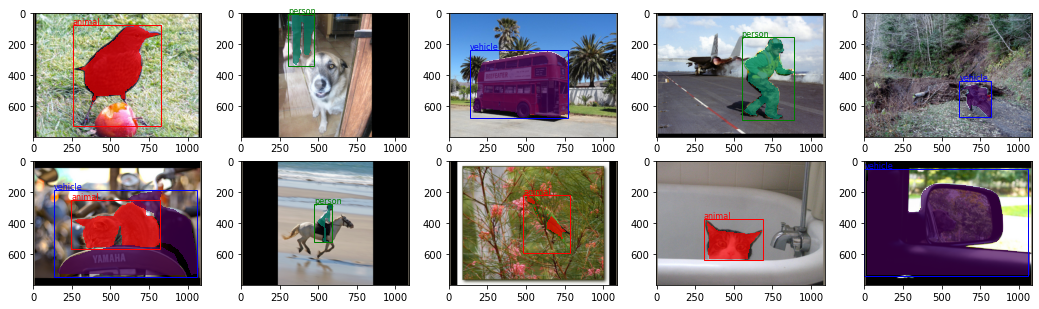

In [ ]:
visualize_dataset(dataset)

## Test for maskhead

In [ ]:
  test_build_loader = BuildDataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  test_loader = test_build_loader.loader()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device) 

cuda


In [ ]:
  box_head = BoxHead(Classes=3,P=7,device=device)
  boxmodel_path = './best_model.pth'
  box_pretrained = torch.load(boxmodel_path, map_location=lambda storage, loc: storage)
  box_head.load_state_dict(box_pretrained)
  box_head.eval()
  mask_head = MaskHead(P=14, device=device)
  box_head.to(device)
  mask_head.to(device)
  model = mask_head
  backbone, rpn = pretrained_models_680('checkpoint680.pth')
  backbone.to(device)
  rpn.to(device)
  # test_build_loader = BuildDataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
  # test_loader = test_build_loader.loader()

  data_batch = next(iter(test_loader))
  images = data_batch['img'].cuda()
  bbox = data_batch["bbox"]
  labels = data_batch["labels"]
  masks = data_batch['masks']
  bbox = [b.to(model.device) for b in bbox]
  labels = [l.to(model.device) for l in labels]
  masks = [m.to(model.device) for m in masks]

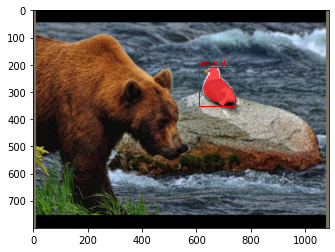

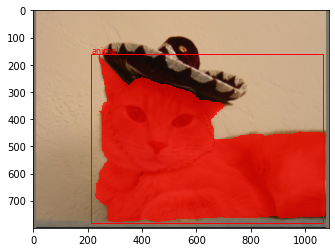

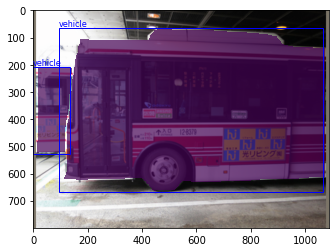

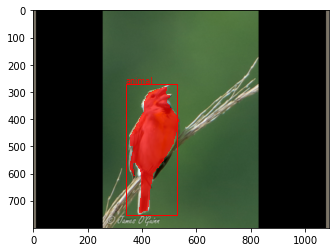

In [ ]:
mask_head = MaskHead(P=14, device=device)
model = mask_head
model.visualize_original(data_batch)

### generate featue vector

In [ ]:
# a = time.time()
backout = backbone(images)
# The RPN implementation takes as first argument the following image list
im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
rpnout = rpn(im_lis, backout)
proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
fpn_feat_list= list(backout.values())
#print(len(proposals))
#print(proposals[0].shape)
# b = time.time()
feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list, proposals, P=box_head.P)
#print(f'feature_vectors.shape{feature_vectors.shape}')
feature_vector_mask = box_head.MultiScaleRoiAlign_mask(fpn_feat_list, proposals, P=mask_head.P)
#print(f'feature_vector_mask{feature_vector_mask.shape}')
# c = time.time()


### test gt creation

In [ ]:
mask_head = MaskHead(P=14, device=device)
model = mask_head.to(device)

class_logits, box_pred = box_head(feature_vectors) # (total proposals,
mask_pred = model(feature_vector_mask)  # (total proposals, C, 28, 28)
# d = time.time()
#print(f'mask_pred.shape{mask_pred.shape}')
box, scores, gt_labels, gt_masks, _ = model.preprocess_ground_truth_creation(
    mask_pred, class_logits, box_pred, proposals, labels, bbox, masks
)
#print(gt_masks[0].shape)

# mask_pred_nms  (nms proposals, C, 28, 28)
print(f'box{ len(box)}')
print(f'gt_labels.shape{gt_labels[0].shape}')
print(f'mask_pred.shape{mask_pred.shape}')
print(f'gt_masks.shape{gt_masks[0].shape}')

box4
gt_labels.shapetorch.Size([100, 1])
mask_pred.shapetorch.Size([400, 3, 28, 28])
gt_masks.shapetorch.Size([100, 28, 28])


### GT visualization

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


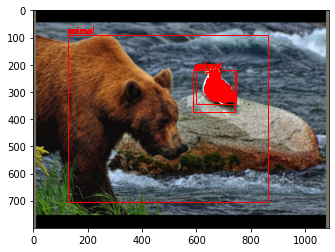

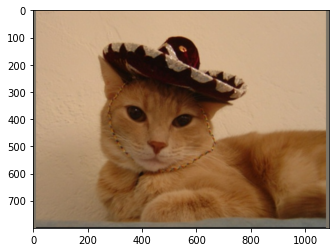

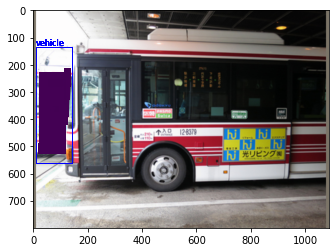

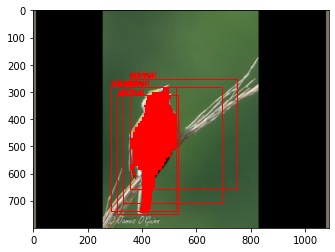

In [ ]:
model = MaskHead(P=14, device=device)
model.visualize_mask(images, box, gt_labels, gt_masks, gt=True)

In [ ]:
model = MaskHead(P=14, device=device)
nms_box, _, nms_labels, projected_masks = model.postprocess_mask(mask_pred, proposals, box_pred, class_logits)

### loss

In [ ]:
mask_head = MaskHead(P=14, device=device)
model = mask_head.to(device)
class_logits, box_pred = box_head(feature_vectors) # (total proposals,
mask_pred = model(feature_vector_mask)  # (total proposals, C, 28, 28)c
# d = time.time()
#print(f'mask_pred.shape{mask_pred.shape}')
box, scores, gt_labels, gt_masks, _ = model.preprocess_ground_truth_creation(
    mask_pred, class_logits, box_pred, proposals, labels, bbox, masks
)
gt_masks = model.flatten_inputs(gt_masks).cuda()# (proposals, C, 28, 28)
gt_labels = model.flatten_inputs(gt_labels).cuda() #(proposals, 1)
loss = model.compute_loss(mask_pred, gt_labels, gt_masks)
print(loss)

tensor(0.2841, device='cuda:0', grad_fn=<DivBackward0>)


### Renew proposal(may not need)

In [ ]:
box_head = BoxHead(Classes=3,P=7,device=device)
boxmodel_path = './best_model.pth'
box_pretrained = torch.load(boxmodel_path, map_location=lambda storage, loc: storage)
box_head.load_state_dict(box_pretrained)
box_head.eval()
class_logits, box_pred = box_head(feature_vectors)
new_proposals = box_head.renew_proposals(proposals, box_pred, class_logits)
print(new_proposals[3][:10])
print(proposals[3][:10])
# box_head.MultiScaleRoiAlign_mask(fpn_feat_list, new_proposals, P=box_head.P)
# print(new_proposals[1][:10])

tensor([[ 85.5200, 333.4489, 710.9072, 800.0000],
        [193.7894, 351.0567, 825.4531, 750.8488],
        [227.7938, 352.3730, 722.5278, 765.5662],
        [274.5483, 388.9957, 639.7083, 757.8149],
        [257.7323, 344.4011, 677.8827, 800.0000],
        [154.8357, 279.6106, 725.8497, 721.9825],
        [143.5670, 392.3040, 653.9247, 767.0729],
        [351.5421, 401.2430, 809.5192, 778.6938],
        [257.8617, 376.6167, 443.1811, 739.3037],
        [241.1044, 347.3350, 638.1540, 799.1525]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[220.7811, 334.0819, 662.6672, 783.3834],
        [204.0865, 398.0123, 898.1175, 779.8997],
        [  8.0963, 420.0685, 676.3359, 776.5453],
        [322.7865, 267.6936, 720.4128, 800.0000],
        [208.4604, 279.9353, 507.0299, 800.0000],
        [  0.0000, 242.6824, 881.2051, 697.9454],
        [274.2151, 415.6920, 604.1350, 762.0349],
        [406.1035, 381.9537, 825.3163, 785.5963],
        [246.7261, 345.3949, 409.1150, 723.2448],

## Train

In [ ]:
def train_mask(dataset, device):
    save_dir = './mask_result'
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    # random split the dataset into training and testset
    print("Data Loading")
    print('batch size', batch_size)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    train_loader = train_build_loader.loader()
    test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = test_build_loader.loader()
    print("Training Set Size", len(train_dataset), "Validation Set Size", len(test_dataset))
    print("Creating Model")
    box_head = BoxHead(Classes=3,P=7,device=device)
    boxmodel_path = './best_model.pth'
    box_pretrained = torch.load(boxmodel_path, map_location=lambda storage, loc: storage)
    box_head.load_state_dict(box_pretrained)
    box_head.eval()
    mask_head = MaskHead(P=14, device=device)
    box_head.to(device)
    mask_head.to(device)
    print("Setting Optimizer")
    optimizer = Adam(mask_head.parameters(), lr=0.001)

    print("Create Backbone")
    # backbone, rpn = pretrained_models_680('checkpoint680.pth')
    # backbone.to(device)
    # rpn.to(device)
    # change to self-trained rpn
    rpn = RPNHead(device=device)
    rpn.load_state_dict(torch.load("./train_result/rpn_best_model.pth"))
    rpn.eval()

    best_loss = 1000.
    early_stopping = 0.
    best_model = None
    loss_total_train = []
    loss_total_val = []
    for i in range(epoch):
        print(f"\nEpoch {i} begins")
        print("Train:")
        loss_total = train(box_head, mask_head, rpn, train_loader, optimizer, i)
        loss_total_train += loss_total
        print("Validation")
        loss_total  = val(box_head, mask_head, rpn, test_loader, i)
        loss_total_val += loss_total
        val_loss_mean = np.mean(np.array(loss_total))
        print("Epoch {} Validation Loss Mean: {:.4f}".format(i, val_loss_mean))
        if val_loss_mean < best_loss:
            best_loss = val_loss_mean
            early_stopping = 0
            best_model = mask_head.state_dict()
        else:
            early_stopping += 1
        if early_stopping == tolerance:
            break
        if (i+1) % 5 == 0:
          torch.save(mask_head.state_dict(), f"{save_dir}/{i}epoch_model.pth")
    torch.save(best_model, f"{save_dir}/best_model.pth")
    np.save(f"{save_dir}/total_train.npy", np.array(loss_total_train))
    np.save(f"{save_dir}/total_val.npy", np.array(loss_total_val))

def train(box_head, model, rpn, loader, optimizer, i):
    loss_mask = []
    model.train()
    for idx, data_batch in enumerate(loader):
        images = data_batch['img'].cuda()
        bbox = data_batch["bbox"]
        labels = data_batch["labels"]
        masks = data_batch['masks']
        bbox = [b.cuda() for b in bbox]
        labels = [l.cuda() for l in labels]
        masks = [m.cuda() for m in masks]
        # a = time.time()
        _, new_coord_list, X = rpn.forward_test(images)
        proposals=[proposal[0:keep_topK,:].detach() for proposal in new_coord_list]

        fpn_feat_list= [t.detach() for t in list(X.values())]

        feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list, proposals, P=box_head.P)
        class_logits, box_pred = box_head(feature_vectors) # (total proposals,
        
        new_proposals = box_head.renew_proposals(proposals, box_pred, class_logits)
        feature_vector_mask = box_head.MultiScaleRoiAlign_mask(fpn_feat_list, new_proposals, P=model.P)
        mask_pred = model(feature_vector_mask)  # (total proposals, C, 28, 28)
        box, scores, gt_labels, gt_masks, _ = model.preprocess_ground_truth_creation(
            mask_pred, class_logits, box_pred, new_proposals, labels, bbox, masks)

        gt_masks = model.flatten_inputs(gt_masks).cuda()# (nms proposals, C, 28, 28)
        gt_labels = model.flatten_inputs(gt_labels).cuda() #(nms proposals, 1)
        loss = model.compute_loss(mask_pred, gt_labels, gt_masks)
        # print('label', np.unique(labels_nms.detach().cpu().numpy()))
        # print('mask_pred', np.unique(mask_pred.detach().cpu().numpy()))
        # print('gt_mask', np.unique(gt_masks.detach().cpu().numpy()))
        # print('train loss', loss.item())
        optimizer.zero_grad()
        if loss == 0:
          continue
        loss.backward()
        optimizer.step()
        loss_mask.append(loss.item())
        
        if idx % 50 == 0:
            print("Epoch {} Batch {}: Total Loss {} ({}) ".format(i, idx, loss.item(), np.array(loss_mask).mean()))
    return loss_mask

def val(box_head, model, rpn, loader, i):
    loss_mask = []
    model.eval()
    for idx, data_batch in enumerate(loader):
        images = data_batch['img'].cuda()
        bbox = data_batch["bbox"]
        labels = data_batch["labels"]
        masks = data_batch['masks']
        bbox = [b.cuda() for b in bbox]
        labels = [l.cuda() for l in labels]
        masks = [m.cuda() for m in masks]
        
        _, new_coord_list, X = rpn.forward_test(images)
        proposals=[proposal[0:keep_topK,:].detach() for proposal in new_coord_list]

        fpn_feat_list= [t.detach() for t in list(X.values())]

        feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list, proposals, P=box_head.P)
        class_logits, box_pred = box_head(feature_vectors) # (total proposals,
        
        new_proposals = box_head.renew_proposals(proposals, box_pred, class_logits)
        feature_vector_mask = box_head.MultiScaleRoiAlign_mask(fpn_feat_list, new_proposals, P=model.P)
        mask_pred = model(feature_vector_mask)  # (total proposals, C, 28, 28)
        box, scores, gt_labels, gt_masks, _ = model.preprocess_ground_truth_creation(
            mask_pred, class_logits, box_pred, new_proposals, labels, bbox, masks)

        gt_masks = model.flatten_inputs(gt_masks).cuda()# (nms proposals, C, 28, 28)
        gt_labels = model.flatten_inputs(gt_labels).cuda() #(nms proposals, 1)
        loss = model.compute_loss(mask_pred, gt_labels, gt_masks)

        loss_mask.append(loss.item())
        if idx % 50 == 0:
            print("Valid Epoch {} Batch {}: Total Loss {} ({}) ".format(i, idx, loss.item(), np.array(loss_mask).mean()))
    return loss_mask

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_mask(dataset, device)